## Group Members
```
20220604 - Adriana Monteiro - 20220604@novaims.unl.pt
20170746 - Inês Nascimento - r20170746@novaims.unl.pt
20220640 - Janaina Santos - 20220640@novaims.unl.pt
20221396 - Stanislav Slesarev - 20221396@novaims.unl.pt
20220609 - Samuel Santos - 20220609@novaims.unl.pt
```
## Data Source link:
https://drive.google.com/drive/folders/1QjoneRXXJAKTP6IdfT0uFn2Qn2CBn1xt?usp=share_link

## Summary

Notebook for hyperparameter tuning. Since our two best models, one of the models of model handcrafted, and another for transfer learning, were performing extremely well, we decided to implement hyperparameter tuning on the base model.

This way, we can determine to what extend hyperparameter tuning is actually capable of improving a less effective model.


## Findings
We started by using Hyperband, as it seemed to be very promising. In fact, the results were not encouraging, as the training only ran for two epochs, regardless of the configuration.

Documentation on this issue was not abundant, but we did find a comment in a forum mentioning this behaviour, and affirming that Hyperband is not a good option for models in which the results have high variations from epoch to epoch - and that is out case.

So, we opted for RandomSearch.

The model did improve significantly using this technique. It predicts all images in the correct classes in training, but in validation, it misclassifies 4 images  in 316, which is not bad, but a sign of a slight overfitting.


## References

1. Keras Tuner, [Documentation](https://keras.io/api/keras_tuner/);
2. Random Search using Keras Tuner, [Documentation](https://keras.io/api/keras_tuner/tuners/random/);


## 1. Notebook setup

### 1.1. Instructions

To run this Notebook, you should:

 - Add the folder (link) as a shortcut to your google drive home/root directory:
https://drive.google.com/drive/folders/1MQihgKcmoiZS0BUjL9kwigmhKmgt8PHJ?usp=share_link

### 1.2. Imports and Installs

In [ ]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 5.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, Sequential, layers, initializers, regularizers, losses, optimizers, metrics
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner

import os
import time
import shutil
import random


import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight



### 1.3. Define global parameters/objects

In [ ]:
# Parameters to run the Notebook

dicParams = {}
dicClasses = {}

dicParams["seed"] = 0
dicParams['gdrive'] = True

dicParams["data_folder"] = '/content/drive/MyDrive/project/cell-cancer-data'

In [ ]:
# Setup drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.4 Import Folders

In [ ]:
# Define the train, validation, and test folder paths

train_folder = dicParams["data_folder"]  + "/train"
val_folder   = dicParams["data_folder"]  + "/val"
test_folder  = dicParams["data_folder"]  + "/test"

### 1.5. Defining Functions

#### 1.5.1 Function plot_confusion_matrix

Given the actual target classes and the predicted target classes for training and validation, and the class names, this function plots the confusion matrix for train and the confusion matrix for validation.

In [ ]:
def plot_confusion_matrix(train_actual, train_predicted, val_actual, val_predicted, labels):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot confusion matrix for training data
    train_cm = tf.math.confusion_matrix(train_actual, train_predicted)
    train_ax = sns.heatmap(train_cm, annot=True, fmt='g', ax=axes[0])
    train_ax.set_title('Training Confusion Matrix')
    train_ax.set_xlabel('Predicted Label')
    train_ax.set_ylabel('Actual Label')
    train_ax.set_xticklabels(labels, rotation=90)
    train_ax.set_yticklabels(labels, rotation=0)

    # Plot confusion matrix for validation data
    val_cm = tf.math.confusion_matrix(val_actual, val_predicted)
    val_ax = sns.heatmap(val_cm, annot=True, fmt='g', ax=axes[1])
    val_ax.set_title('Validation Confusion Matrix')
    val_ax.set_xlabel('Predicted Label')
    val_ax.set_ylabel('Actual Label')
    val_ax.set_xticklabels(labels, rotation=90)
    val_ax.set_yticklabels(labels, rotation=0)

    plt.tight_layout()
    plt.show()



#### 1.5.2. Preprocessing Function

This function was created in the preprocessing notebook (where it is described in further detail) to automate the loading of datasets.

In [ ]:
def preprocessing(data_folder, seed=42, train=True,
                  image_size=(96, 128),
                  crop_to_aspect_ratio=True,
                  color_mode='rgb',
                  batch_size=64,
                  labels='inferred',
                  label_mode='categorical',
                  class_names=['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B'],
                  shuffle=True,
                  weight=False,
                  augmentation=False):

    ds_folder = image_dataset_from_directory(data_folder,
                                              image_size=image_size,
                                              crop_to_aspect_ratio=crop_to_aspect_ratio if train else False,
                                              color_mode=color_mode,
                                              batch_size=batch_size,
                                              labels=labels,
                                              label_mode=label_mode,
                                              class_names=class_names,
                                              shuffle=shuffle,
                                              seed=seed)

    class_weight_dict = None
    if train and weight:
        y_train_labels = np.concatenate([y for x, y in ds_folder], axis=0)
        y_train_indices = np.argmax(y_train_labels, axis=1)
        unique_classes = np.unique(y_train_indices)
        class_weights = class_weight.compute_class_weight('balanced', classes=unique_classes, y=y_train_indices)
        class_weight_dict = dict(zip(unique_classes, class_weights))
        print("Class weights:", class_weight_dict)

    datagen = None
    ds_train_augmented = None
    if train and augmentation:
        datagen = ImageDataGenerator(rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

        ds_train_augmented = datagen.flow_from_directory(data_folder,
                                                         target_size=image_size,
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         shuffle=True,
                                                         seed=seed,
                                                         classes=class_names)
        ds_folder = ds_train_augmented

    #Creating an iterator object for ds_train
    input_shape = None
    if train:
      iter_train = iter(ds_folder)
      batch_x_train, batch_y_train = iter_train.next()
      input_shape = (batch_x_train.shape)

    return ds_folder, class_weight_dict, input_shape

### 1.6 Define Model's Parameters

In [ ]:
dicModelParams = {}
dicModelParams["image_size"] = (96,128)
dicModelParams["crop_to_aspect_ratio"] = True
dicModelParams["color_mode"] = 'rgb'
dicModelParams["batch_size"] = 64
dicModelParams["labels"] = 'inferred'
dicModelParams["label_mode"] = 'categorical'
dicModelParams["class_names"] = ['Benign', '[Malignant] Pre-B','[Malignant] Pro-B', '[Malignant] early Pre-B']
dicModelParams["shuffle"] = True
dicModelParams["seed"] = dicParams["seed"]
dicModelParams["interpolation"] = 'bilinear'
dicModelParams["optimizer"] = None        
dicModelParams["learning_rate"] = 0.001
dicModelParams["epochs"] = 30

### 1.7 Creating dataset instances - Original and Preprocessed

Loading datasets (train, val, test) for hypersearch

In [ ]:
ds_train, _ , input_shape = preprocessing(train_folder, train=True, seed=dicModelParams["seed"]) #original
ds_val, _ , _ = preprocessing(val_folder,train=False, seed=dicModelParams["seed"]) #validation
ds_test, _ , _ = preprocessing(test_folder,train=False, seed=dicModelParams["seed"]) # test


Found 2558 files belonging to 4 classes.
Found 316 files belonging to 4 classes.
Found 328 files belonging to 4 classes.


## 2. Hyperparameter Tuning

Initialize an object to store Keras_tuner Hyperparameters

In [ ]:
#initializing hp object

hp = keras_tuner.HyperParameters()

### 2.1. Defining and preparing the Model for Tuning

#### 2.1.1. BottleneckBlock

Define the bottleneck block that will be invoked from the sequential model trained for hypertuning.

In [ ]:
class BottleneckBlock(tf.keras.Model):  
    def __init__(self, in_filters, squeeze=4, expand=1, downsample=False, seed=0):
        super().__init__()
        # Store values as instance attributes
        self.downsample = downsample        
        self.expand = expand
        self._squeeze = in_filters//squeeze    
        # Low dimensional projection
        self.conv1 = layers.Conv2D(self._squeeze, kernel_size=1, padding='same',
                                   strides=2 if self.downsample else 1,
                                   kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
        # Perform feature extraction on the reduced feature maps
        self.conv2 = layers.Conv2D(self._squeeze, kernel_size=3, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
        # High dimensional projection
        self.conv3 = layers.Conv2D(in_filters*self.expand, kernel_size=1, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
        self.relu = layers.Activation("relu")
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        if self.expand > 1 or self.downsample:
            self.conv1x1 = layers.Conv2D(in_filters*self.expand, kernel_size=1, 
                                         strides=2 if self.downsample else 1,
                                         kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
    
    def call(self, inputs):        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.expand > 1 or self.downsample:
            x += self.conv1x1(inputs) 
        else:
            x += inputs
        x = self.relu(x)        
        return x


#### 2.1.2. CustomResNet

In the next cell, we define the function for building the model inside of the Keras Tuner hyperparameter search.

We decided to optimize two parameters:
- learning_rate, as it is know to usually have significant impact on the model's performance;
- activation function, thereby changing the way in which the model determines which neurons are activated. There were other interesting hyperparameters to experiment with, but we wanted to use also hyperparameter tuning over a discrete list of values (using Choice).


In [ ]:
def model_builder(hp):

  model = Sequential([
                  layers.BatchNormalization(),
                  layers.Conv2D(filters=64,
                                  kernel_size=7,
                                  strides=2,
                                  padding="same",
                                  kernel_initializer=initializers.GlorotNormal(seed=dicParams["seed"])
                                  ),
                  layers.BatchNormalization(),
                  layers.Activation(hp.Choice("activation",["relu","tanh","sigmoid"])),
                  layers.MaxPooling2D(pool_size=3, strides=2),
                  BottleneckBlock(in_filters=64, squeeze=1, expand=1, downsample=True, seed=dicParams['seed']),
                  BottleneckBlock(in_filters=128, squeeze=2, expand=1, downsample=True, seed=dicParams['seed']),

                  layers.GlobalMaxPooling2D(),
                  layers.Dense(units=4, activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=dicParams["seed"]))
                    ]
)

  iter_train = iter(ds_train)
  batch_x, batch_y = iter_train.next()

  input_shape = tuple(batch_x.shape)
  model.build(input_shape)

  model.compile(loss=losses.CategoricalCrossentropy(),
                optimizer = optimizers.SGD(learning_rate=hp.Float("learning_rate", min_value = 0.0001, max_value=1, step=0.0001)),
                metrics = [metrics.CategoricalAccuracy(name='accuracy'),
                           metrics.Recall(name='recall')])
  return model


As explained in the findings section, after extensive experimentation with Hyperband, we opted for RandomSearch.


In [ ]:

myt = keras_tuner.RandomSearch(model_builder, objective=keras_tuner.Objective('val_recall', direction='max'), max_trials=10, seed= dicParams['seed'], overwrite=True)
myt.search(ds_train, validation_data=ds_val, epochs=15)


Trial 10 Complete [00h 09m 46s]
val_recall: 0.7689873576164246

Best val_recall So Far: 0.9873417615890503
Total elapsed time: 01h 43m 52s


In the base model we obtained a validation recall .9608, in 30 epochs, and that was beneficting from image augmentation.

Using RandomSearch we were able to significantly improve on the results obtained in the base model, obtaining a validation recall of .9873, after only 15 epochs, and without image augmentation.



We now output the optimized results for the hyperparameters, and then summarize the random search over all the trials.

In [ ]:
hyperparameter_tuner = myt

best_model = hyperparameter_tuner.get_best_models(1)[0]

# Retrieve the hyperparameters of the best model
best_hyperparameters = hyperparameter_tuner.get_best_hyperparameters(1)[0]

# Access specific hyperparameter values
best_activation = best_hyperparameters.get('activation')
best_learning_rate = best_hyperparameters.get('learning_rate')
# ... access other hyperparameters ...

print("Best Hyperparameters:")
print("Activation:", best_activation)
print("Learning Rate:", best_learning_rate)



Best Hyperparameters:
Activation: relu
Learning Rate: 0.058


In [ ]:
myt.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_recall", direction="max")

Trial 06 summary
Hyperparameters:
activation: relu
learning_rate: 0.058
Score: 0.9873417615890503

Trial 05 summary
Hyperparameters:
activation: tanh
learning_rate: 0.5264
Score: 0.9620253443717957

Trial 02 summary
Hyperparameters:
activation: sigmoid
learning_rate: 0.0012000000000000001
Score: 0.8892405033111572

Trial 09 summary
Hyperparameters:
activation: sigmoid
learning_rate: 0.6057
Score: 0.7689873576164246

Trial 03 summary
Hyperparameters:
activation: sigmoid
learning_rate: 0.6465000000000001
Score: 0.7658227682113647

Trial 01 summary
Hyperparameters:
activation: relu
learning_rate: 0.7115
Score: 0.3069620132446289

Trial 07 summary
Hyperparameters:
activation: relu
learning_rate: 0.6846
Score: 0.16139240562915802

Trial 08 summary
Hyperparameters:
activation: sigmoid
learning_rate: 0.8733000000000001
Score: 0.16139240562915802

Trial 00 summary
Hyperparameters

We will now rerun the model, using the parameters obtained by hyperparameter tuning, in order to produce the confusion matrices for train and validation.


In [ ]:
## new optimized parameters

hyper_learning_rate = 0.058
hyper_activation = 'relu'

In [ ]:
model_hyper = Sequential([
                  layers.BatchNormalization(),
                  layers.Conv2D(filters=64,
                                  kernel_size=7,
                                  strides=2,
                                  padding="same",
                                  kernel_initializer=initializers.GlorotNormal(seed=dicParams["seed"])
                                  ),
                  layers.BatchNormalization(),
                  layers.Activation(hyper_activation),
                  layers.MaxPooling2D(pool_size=3, strides=2),
                  BottleneckBlock(in_filters=64, squeeze=1, expand=1, downsample=True, seed=dicParams['seed']),
                  BottleneckBlock(in_filters=128, squeeze=2, expand=1, downsample=True, seed=dicParams['seed']),

                  layers.GlobalMaxPooling2D(),
                  layers.Dense(units=4, activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=dicParams["seed"]))
                    ]
)

iter_train = iter(ds_train)
batch_x, batch_y = iter_train.next()

input_shape = tuple(batch_x.shape)
model_hyper.build(input_shape)

In [ ]:
model_hyper.compile(loss=losses.CategoricalCrossentropy(),
                optimizer = optimizers.SGD(learning_rate=hyper_learning_rate),
                metrics = [metrics.CategoricalAccuracy(name='accuracy'),
                           metrics.Recall(name='recall')])

In [ ]:
hyper_history = model_hyper.fit(ds_train, epochs=15, validation_data=ds_val)

Epoch 1/15
40/40 [==============================] - 217s 5s/step - loss: 1.6528 - accuracy: 0.7420 - recall: 0.7299 - val_loss: 24.6608 - val_accuracy: 0.3006 - val_recall: 0.3006
Epoch 2/15
40/40 [==============================] - 36s 700ms/step - loss: 0.1736 - accuracy: 0.9464 - recall: 0.9406 - val_loss: 11.3034 - val_accuracy: 0.3006 - val_recall: 0.3006
Epoch 3/15
40/40 [==============================] - 33s 708ms/step - loss: 0.1104 - accuracy: 0.9683 - recall: 0.9636 - val_loss: 3.7472 - val_accuracy: 0.5032 - val_recall: 0.4873
Epoch 4/15
40/40 [==============================] - 32s 675ms/step - loss: 0.0745 - accuracy: 0.9769 - recall: 0.9738 - val_loss: 2.5041 - val_accuracy: 0.5633 - val_recall: 0.5032
Epoch 5/15
40/40 [==============================] - 35s 772ms/step - loss: 0.0543 - accuracy: 0.9855 - recall: 0.9836 - val_loss: 1.7035 - val_accuracy: 0.4304 - val_recall: 0.4019
Epoch 6/15
40/40 [==============================] - 31s 658ms/step - loss: 0.0272 - accuracy: 0

2/2 [==============================] - 0s 252ms/step


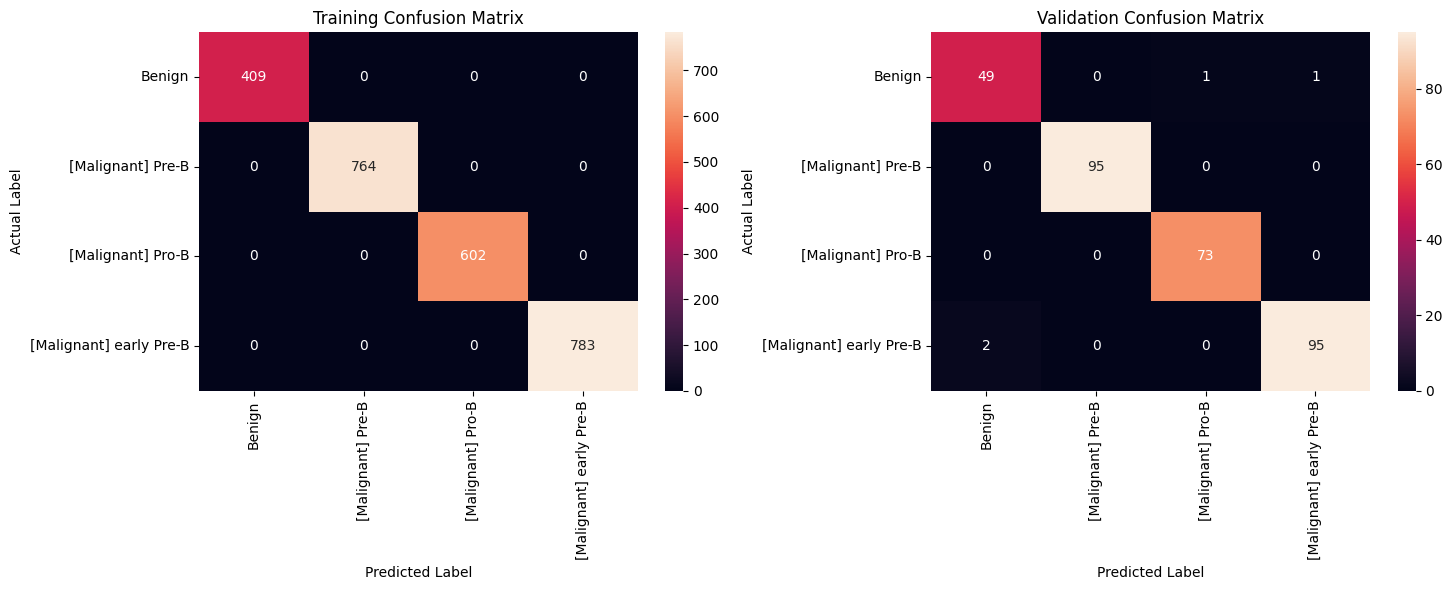

In [ ]:
predictions_train = np.array([])
labels_train =  np.array([])
for x, y in ds_train:
  labels_train = np.concatenate([labels_train, np.argmax(y.numpy(), axis=-1)])                   #true label
  predictions_train = np.concatenate([predictions_train, np.argmax(model_hyper.predict(x), axis = -1)]) #predicted label

predictions_val = np.array([])
labels_val =  np.array([])
for x, y in ds_val:
  labels_val = np.concatenate([labels_val, np.argmax(y.numpy(), axis=-1)])                   #true label
  predictions_val = np.concatenate([predictions_val, np.argmax(model_hyper.predict(x), axis = -1)]) #predicted label


plot_confusion_matrix(labels_train, predictions_train, labels_val, predictions_val,dicModelParams["class_names"] )


As we can see, the model predicts all images in the correct classes in training, but in validation, it misclassifies 4 images  in 316, which is not bad, but a sign of a slight overfitting.
